# A demonstration of the GalPot python wrapper, and orbit integrator

The wrapper allows one to call GalPot from Python if one so desires. I'll show some examples below


In [1]:
# Some helpful imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

plt.rcParams['xtick.minor.visible'], plt.rcParams['xtick.top'] = True,True
plt.rcParams['ytick.minor.visible'], plt.rcParams['ytick.right'] = True,True
plt.rcParams['xtick.direction'], plt.rcParams['ytick.direction'] = 'in','in' 

# Import GalaxyPotential class

In [2]:
from GalPot import GalaxyPotential

# Make a potential from file

## In this case we'll take the potential from McMillan (2017)

Other potentials are available in the same directory. Or you can write your own.

In [3]:
Phi = GalaxyPotential("pot/PJM17_best.Tpot")

### All the internal workings are in units M<sub>sun</sub>, kpc, Myr (as in the c++ code)

Conversions for velocities can be applied with the helpful GalaxyPotential value kpc_Myr_to_km_s (=977.77)

Here's what we can do

In [4]:

Rsun = 8.2
zsun = 0.014

# Find Potential
Phi.Potential(Rsun,zsun)

-0.1916462926763608

Find derivatives wrt R & z of potential

In [5]:
Phi.Potential_derivatives(Rsun,zsun)

(-0.19164629267636077, 0.006931271081614127, 8.953825922054219e-05)

Find density at a position

In [6]:
Phi.Density(Rsun,zsun)

111445118.32667452

Find circular velocity (and its square - note how the units are adjusted)

In [7]:
Phi.Vcirc2(Rsun)*Phi.kpc_Myr_to_km_s**2 ,Phi.Vcirc(Rsun)*Phi.kpc_Myr_to_km_s

(54339.024150363366, 233.1073232448165)

Find mass within a given radius

In [8]:
Phi.Mass(Rsun)

93430344014.61429

Find epicycle frequencies

In [9]:
kap,nu,om = Phi.KapNuOm(Rsun)
kap,nu,om

(0.041101899647224174, 0.08050231553307938, 0.029074038216481222)

Find radius/angular momentum of circular orbit, given the other

In [10]:
Phi.RfromLc(Rsun*Phi.Vcirc(Rsun)), Phi.LfromRc(Rsun)*Phi.kpc_Myr_to_km_s

(8.200001906956087, 1911.4797374278335)

# Some of these routines also accept arrays as input. 

## For example, we can plot the rotation curve thus:


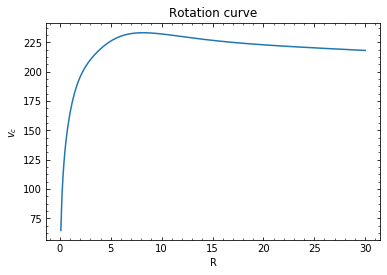

In [11]:
R_arr = np.linspace(0.1,30,300)
plt.plot(R_arr, Phi.Vcirc(R_arr)*Phi.kpc_Myr_to_km_s)
plt.xlabel('R')
plt.ylabel(r'$v_c$')
plt.title('Rotation curve')
plt.show()


## Or the potential as a function of R,z

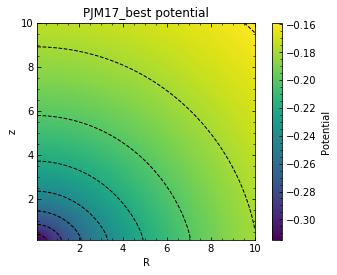

In [12]:
R_arr = np.linspace(0.1,10,100)
z_arr = np.linspace(0.1,10,100)
RRgrid, ZZgrid = np.meshgrid(R_arr,z_arr)
Pot = Phi.Potential(np.array(RRgrid).flatten(),np.array(ZZgrid).flatten())
Pot = Pot.reshape(RRgrid.shape)

plt.imshow(Pot, origin='lower',aspect=1.,
           extent=[np.min(R_arr),np.max(R_arr),np.min(z_arr),np.max(z_arr)])
plt.gca().set_aspect('equal')

plt.colorbar(label='Potential')
plt.contour(RRgrid,ZZgrid,Pot,colors='k',linewidths=1)
plt.xlabel('R')
plt.ylabel('z')
plt.title('PJM17_best potential')
plt.show()

# Orbit integration

### As of June 2019, the orbit integration routines in c++ have a Python wrapper, which we now demonstrate below. They are much much quicker than using the python routines (see last few cells of the notebook).

Below we give a examples of integrating the orbit of the Sun


In [13]:
# Position & velocity - R, z, phi, VR, vz, v
# We will use the position and velocity of the Sun (from McMillan 2017)
xv_ini = np.array([8.21,0.014,0,
                   -11.1/Phi.kpc_Myr_to_km_s,7.25/Phi.kpc_Myr_to_km_s,(-233.1-12.24)/Phi.kpc_Myr_to_km_s])



### If all we want are the properties of an orbit, we can simply ask for them.

#### By default they are calculated over a 13.8 Gyr integration.

In [14]:
from GalPot import OrbitIntegrator
# Setup with potential
OI = OrbitIntegrator(Phi)
# Get stats
OI.getOrbitStats(xv_ini)

OrbitStat(Energy=-0.16000519679316683, Lz=-2.0600360002863662, Pericentre=8.13226411771589, Apocentre=9.221374196664122, Zmax=0.10491970243391335, GuidingRadius=8.64404202629955, PseudoEccentricity=0.06275975442254933)

### Or if we want the properties of many orbits, and want to do it all at once...

In [15]:
norb = 3

R_ini = np.linspace(7,9,norb)
z_ini = np.linspace(0.5,2.,norb)
phi_ini = np.zeros_like(R_ini)
vR_ini = -11.1/Phi.kpc_Myr_to_km_s * np.ones_like(R_ini)
vz_ini = 7.25/Phi.kpc_Myr_to_km_s * np.ones_like(R_ini)
vphi_ini = (-233.1-12.24)/Phi.kpc_Myr_to_km_s * np.ones_like(R_ini)

OrbitInput = np.vstack([R_ini,z_ini,phi_ini,vR_ini,vz_ini,vphi_ini]).T
OrbitStatistics = OI.getOrbitStats(OrbitInput)
OrbitStatistics.Pericentre

array([6.95753219, 8.02214792, 9.174181  ])

# Orbital path

Below we show how to integrate an orbit (specifically the Sun's orbit) for 1.5 Gyr using the wrapper for the C++ integrator with GalPot, returning points along the path at the specified times.

We then plot position in the R-z and x-y planes for the orbit


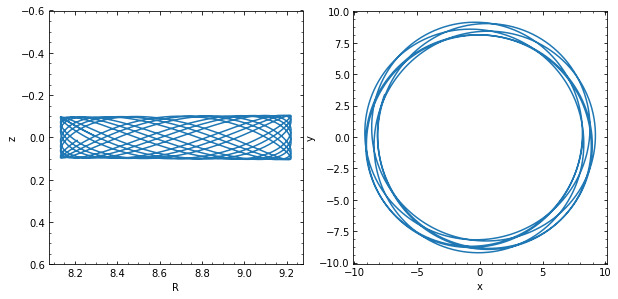

In [16]:
# times we want to know about
t_eval=np.linspace(0,1500,5000)

# run the code
OrbitPath,OrbitStatistics = OI.getOrbitPathandStats(xv_ini,t_eval)


R    = OrbitPath[:,0]
z    = OrbitPath[:,1]
phi  = OrbitPath[:,2]
vR   = OrbitPath[:,3]
vz   = OrbitPath[:,4]
vphi = OrbitPath[:,5]

plt.gcf().set_size_inches(10, 5)
plt.subplot(121)
plt.plot(R,z)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
if ymax-ymin < xmax-xmin :
    plt.ylim(0.5*(xmax-xmin), -0.5*(xmax-xmin))
    
plt.gca().set_aspect('equal')
plt.xlabel('R')
plt.ylabel('z')
plt.subplot(122)
plt.plot(R*np.cos(phi),R*np.sin(phi))
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.show()

### Or, again, many orbital paths if we so desire...

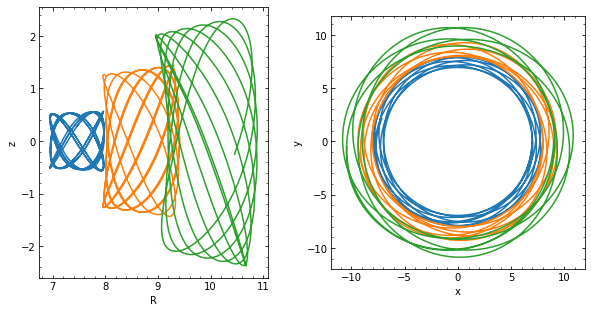

In [17]:

OrbitPath,OrbitStatistics = OI.getOrbitPathandStats(OrbitInput,t_eval)

# take transpose such that we end up plotting the orbits properly.
R    = OrbitPath[:,:,0].T
z    = OrbitPath[:,:,1].T
phi  = OrbitPath[:,:,2].T
vR   = OrbitPath[:,:,3].T
vz   = OrbitPath[:,:,4].T
vphi = OrbitPath[:,:,5].T

plt.gcf().set_size_inches(10, 5)
plt.subplot(121)
plt.plot(R,z)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
if ymax-ymin < xmax-xmin :
    plt.ylim(0.5*(xmax-xmin), -0.5*(xmax-xmin))
    
plt.gca().set_aspect('equal')
plt.xlabel('R')
plt.ylabel('z')
plt.subplot(122)
plt.plot(R*np.cos(phi),R*np.sin(phi))
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.show()

# We can integrate an orbit backwards as well as forwards*. Here we do this for an orbital time of 13.8 Gyr (backwards), and do some checks.

#### *(though the code is not set up to integrate forwards and backwards in the same calculation - you'd have to run it twice)

In [18]:

t_eval=np.linspace(0,-13800,5000)

OrbitPath,OrbitStatistics = OI.getOrbitPathandStats(xv_ini,t_eval)


R    = OrbitPath[:,0]
z    = OrbitPath[:,1]
phi  = OrbitPath[:,2]
vR   = OrbitPath[:,3]
vz   = OrbitPath[:,4]
vphi = OrbitPath[:,5]

## Plot energy as a check of numerical accuracy

Note that matplotlib does odd things to the y-axis when the difference is small compared to the absolute value. The change in each value should be small compared to the total value (which may be shown above the y-axis)

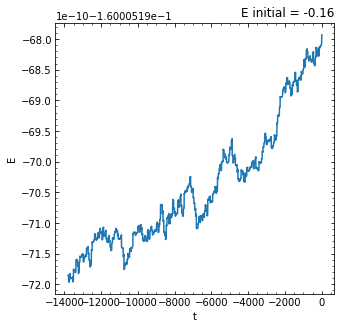

In [19]:



plt.gcf().set_size_inches(5, 5)
energy = 0.5*(vR**2+vz**2+vphi**2) + Phi.Potential(R,z)
plt.plot(t_eval,energy)
plt.xlabel('t')
plt.ylabel('E')
plt.title('E initial = %.2f' % energy[0],loc='right')
plt.show()

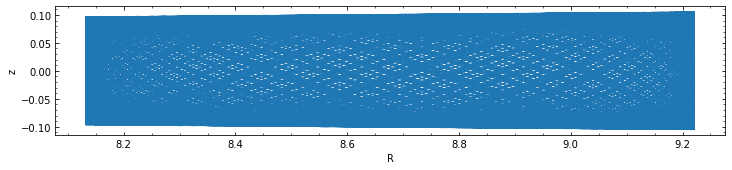

In [20]:

plt.gcf().set_size_inches(12,4)
plt.plot(R,z)
    
plt.xlabel('R')
plt.ylabel('z')
plt.gca().set_aspect('equal')
plt.show()

## We can also plot an approximate surface of section (R, vR at z=0 for the orbit)

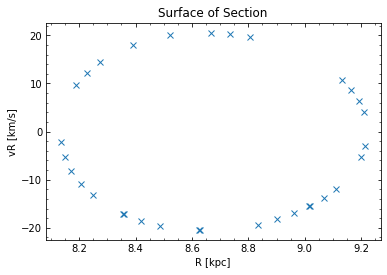

In [21]:
# Simple mask to find values at z ~ 0
mask = np.absolute(z) < 0.01*np.max(z)

plt.plot(R[mask],vR[mask]*Phi.kpc_Myr_to_km_s, 'x')

plt.xlabel('R [kpc]')
plt.ylabel('vR [km/s]')
plt.title('Surface of Section')
plt.show()

# Using the GalPot orbit integrator

We can now access the GalPot c++ orbit integration routines directly. For example, if we just want the properties of an orbit...

## We can also get an orbit path this way...

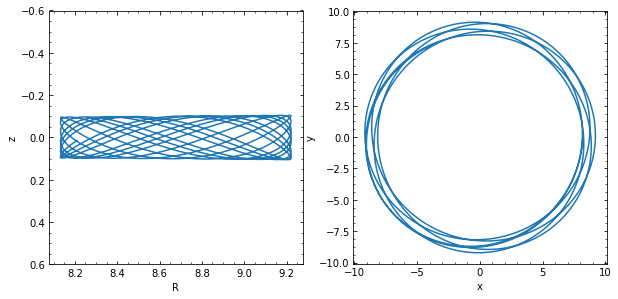

In [22]:
t_limits = (0,1300.)
t_eval=np.linspace(0,1300,5000)

# integrate the orbit
orb = scipy.integrate.solve_ivp(Phi.XVDerivative, t_limits, xv_ini,
                                method='RK45',t_eval=t_eval,rtol=1e-5)
# new in scipy 1.0.0 - this part will only work if your scipy install is relatively up to date

# N.B. the choice of rtol is (semi-)arbitrary here. 
# It determines the precision or the orbital integration.
# Higher values may be required for some cases, and lower may be preferred to 
# increase computation speed in other cases

R    = orb.y[0]
z    = orb.y[1]
phi  = orb.y[2]
vR   = orb.y[3]
vz   = orb.y[4]
vphi = orb.y[5]

plt.gcf().set_size_inches(10, 5)
plt.subplot(121)
plt.plot(R,z)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
if ymax-ymin < xmax-xmin :
    plt.ylim(0.5*(xmax-xmin), -0.5*(xmax-xmin))
    
plt.gca().set_aspect('equal')
plt.xlabel('R')
plt.ylabel('z')
plt.subplot(122)
plt.plot(R*np.cos(phi),R*np.sin(phi))
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.show()

## For completeness I still show here how to do the integration in python (calling GalPot for the potential)

# I cannot emphasise enough how much faster the c++ code is. 

## Below I illustrate with some example code which does basically the same thing but 10-20 times faster for the c++


The GalaxyPotential class has a couple of functions that take input position and velocity (as a single array). These are useful for orbit integration. 

XVDerivative, which is actually used in the integration routine, requires an aditional input t (which is not actually used), to fit with the integration routine we use below. It gives the derivative of xv_cyl with respect to t.


In [23]:
t=0.

# Acceleration (n.b. includes centrifugal force), and derivative of phase space point
Phi.Acceleration(xv_ini), Phi.XVDerivative(t,xv_ini)

(array([ 7.45857562e-04, -8.92739656e-05, -3.46956291e-04]),
 array([-1.13523630e-02,  7.41483171e-03, -3.05624732e-02,  7.45857562e-04,
        -8.92739656e-05, -3.46956291e-04]))

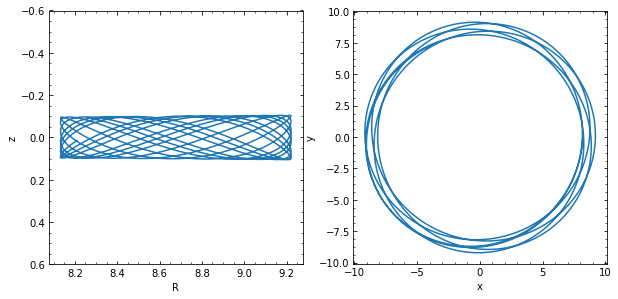

In [24]:
t_limits = (0,1300.)
t_eval=np.linspace(0,1300,5000)

# integrate the orbit
orb = scipy.integrate.solve_ivp(Phi.XVDerivative, t_limits, xv_ini,
                                method='RK45',t_eval=t_eval,rtol=1e-5)
# new in scipy 1.0.0 - this part will only work if your scipy install is relatively up to date

# N.B. the choice of rtol is (semi-)arbitrary here. 
# It determines the precision or the orbital integration.
# Higher values may be required for some cases, and lower may be preferred to 
# increase computation speed in other cases

R    = orb.y[0]
z    = orb.y[1]
phi  = orb.y[2]
vR   = orb.y[3]
vz   = orb.y[4]
vphi = orb.y[5]

plt.gcf().set_size_inches(10, 5)
plt.subplot(121)
plt.plot(R,z)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
if ymax-ymin < xmax-xmin :
    plt.ylim(0.5*(xmax-xmin), -0.5*(xmax-xmin))
    
plt.gca().set_aspect('equal')
plt.xlabel('R')
plt.ylabel('z')
plt.subplot(122)
plt.plot(R*np.cos(phi),R*np.sin(phi))
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.show()

In [25]:
r = (orb.y[0]**2+orb.y[1]**2)**0.5
print('Pericentre = %.2f kpc' % np.min(r))
print('Apocentre = %.2f kpc' % np.max(r))
print('z max = %.2f kpc' % np.max(z) )
print('Mean r = %.2f kpc' % np.mean(r) )
print('PseudoEccentricity = %.2f' % ((np.max(r)-np.min(r))/(np.max(r)+np.min(r))))
print('Please note that eccentricity is not a well defined quantity in a non-spherically symmetric potential')


Pericentre = 8.13 kpc
Apocentre = 9.22 kpc
z max = 0.10 kpc
Mean r = 8.69 kpc
PseudoEccentricity = 0.06
Please note that eccentricity is not a well defined quantity in a non-spherically symmetric potential


# Timing comparison

### Below, we compare the time taken by the python integrator vs the time taken by the direct c++ integrator.

In [26]:
t_limits = (0,13800.)
t_eval=np.linspace(0,13800,100)

# Use python integration routines
print('Python version:')
%timeit scipy.integrate.solve_ivp(Phi.XVDerivative, t_limits, xv_ini,method='RK45',t_eval=t_eval,rtol=1e-5)
# Use c++ routines - just get the orbital parameters
print('C++ version, stats only:')
%timeit OI.getOrbitStats(xv_ini,t_limits[1])
# Use c++ routines - get path and orbital parameters
print('C++ version, path and stats:')
%timeit OI.getOrbitPathandStats(xv_ini,t_eval)

Python version:
401 ms ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
C++ version, stats only:
20.3 ms ± 727 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
C++ version, path and stats:
19.6 ms ± 757 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
#cleanup
del Phi
del OI